# set-up

In [1]:
# load required libraries
import pandas as pd
import sys
import ndex2
from getpass import getpass
import cdapsutil
import pandas as pd
import mygene
mg = mygene.MyGeneInfo()
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import obonet as obo
import networkx as nx
import requests
import scipy.stats as stats
import numpy as np
from adjustText import adjust_text
import matplotlib.patches as mpatches
import json
import os
os.chdir('/tscc/projects/ps-palmer/brittany/ddot')
import ddot
from netcoloc import netprop_zscore, netprop, network_colocalization, validation
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks')
from rca_functions import import_seedgenes, import_interactome
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *

In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [3]:
#create a file called environ_ndex_meta.py where you save variables 'ndex_user' and 'ndex_password'
#otherwise will prompt you to define those within the notebooks
if os.path.isfile('../environ_ndex_meta.py'):
    print ('NDEx credentials imported from meta file')
    sys.path.insert(1, '../')
    from environ_ndex_meta import *
    sys.path.pop(1)
else:
    # Prompt the user for a username
    ndex_user = input("Enter your NDEx username: ")
    # Prompt the user for a password
    ndex_password = input("Enter your NDEx password: ")

NDEx credentials imported from meta file


# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [4]:
interactome_name='PCNet2.0'

In [5]:
interactome=import_interactome(UUIDs=UUIDs, interactome_name=interactome_name)
all_nodes=list(interactome.nodes())

PCNet2.0
Name: PCNet 2.0
Nodes: 19267
Edges: 3852119
Node Attributes: 19267
Edge Attributes: 19260595

number of nodes:
19267

number of edges:
3852119


# import NPS scores and seed genes

In [6]:
seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,all_nodes)
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR'])

In [7]:
#dictionary of human control traits
ctrl_dict={}
ctrl_traits=['facial_hair', 'age_smkinit', 'antisoc', 'friend_sat', 'hr', 'infant_bw', 'LDL', 'maternal_smok', 'townsend', 'age_menarche', 'neurot','addict-rf']
for t in ctrl_traits:
    ctrl_dict[t]=pd.read_csv('gwas_ctrl_hm/magma/seed_genes/'+t+'_annot.tsv',sep='\t')
for t in ctrl_traits:
    seed_dict[t+'_FDR']=(set(ctrl_dict[t][ctrl_dict[t]['Q']<0.05]['GENE']))
    seed_dict[t+'_bonf']=(set(ctrl_dict[t][ctrl_dict[t]['P']<0.05/len(ctrl_dict[t])]['GENE']))
    seed_dict[t+'_top500']=set(ctrl_dict[t][(ctrl_dict[t]['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])

In [8]:
NPS_dict,NPS_dict_series=import_NPS_scores(seed_dict,UUIDs)

# import MGI datasets

In [9]:
# load mappings between genes and mammalian phenotypes
mgi_df = validation.load_MGI_mouseKO_data()
print("Number of gene-phenotype associations:", len(mgi_df))
# import table of names of MPO terms
MPO_desc=import_MPO_description()
#import the MPO in graph format
graph = obo.read_obo('http://www.informatics.jax.org/downloads/reports/MPheno_OBO.ontology')
#subset the graph to remove obsolete terms
graph=graph.subgraph(list(set(MPO_desc[~MPO_desc['description'].str.contains('obsolete')].index)))
#get id from name or name from ID 
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

33 input query terms found dup hits:	[('Adam1a', 2), ('Betalinc1', 2), ('Cast', 2), ('Chaserr', 2), ('Dnajb3', 2), ('Dnm3os', 2), ('Eldr'
12723 input query terms found no hit:	['+|Cav1', '+|Cm', '+|Del(10Prmt2-Pdxk)4Yey', '+|Del(11Mpo-Chad)18Brd', '+|Del(11Rr325)1Smun', '+|De


25820
13097
13064
Number of gene-phenotype associations: 384558


/tscc/projects/ps-palmer/brittany/ddot/ddot/Ontology.py:394: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(id2namespace).to_csv(id2namespace_file, sep='\t')


15453


In [10]:
par=[id_to_name[x] for x in graph.predecessors('MP:0000001')]

In [11]:
gpt_path='validation_datasets/MGI_genes_per_trait_MP.csv'
if (os.path.isfile(gpt_path)):
    genes_per_trait=pd.read_csv(gpt_path)
    print('reading in file')
else:
    print('calculating genes per trait')
    genes_per_trait=count_genes_per_trait(['MP:0000001'],mgi_df,'human_ortholog','MP',id_to_name,name_to_id,graph)
    genes_per_trait.to_csv(gpt_path,index=False)

reading in file


# choose dataset for analysis- put gene lists into dictionary

In [12]:
#modify for correct genesets
cut_r= 'FDR'
cut_h='top500'
trait_r='loco_gsem'
trait_h='ext'

#choose which community to check enrichment for
#must be keys from coloc_dict
sub_community='net'

label_h,label_r,seed_h,seed_r,NPS_h,NPS_r,NPS=return_analysis_datasets(trait_r,cut_r,trait_h,cut_h,seed_dict,NPS_dict,interactome_name)


In [14]:
filter_traits=False
gpt=genes_per_trait[(genes_per_trait.ngenes>=5)&(genes_per_trait.ngenes<=1e5)]

In [15]:
#get rest of datasets based on what was specified above
coloc_dict=def_coloc_dict(seed_r,seed_h,NPS,all_nodes,cut_single,cut_comb,cut_rat_specific,cut_hm_specific)
val_lab_dict=def_val_label_dict(label_h,label_r,interactome_name,cut_single,cut_comb)

In [16]:
#sub_community is the community being tested for enrichment (i.e. the ext-loco network, 'net')
#whole_community is the greater pool of genes to test against (i.e. PCNET ('graph'))
if sub_community in val_lab_dict.keys():
    whole_community=coloc_dict_ref[sub_community]
    outpath=f'validation_output/MGI_enr_{val_lab_dict[sub_community]}_enr.csv'

else:
    print('sub_community not in val_lab_dict- using graph as the whole_community')
    whole_community='graph'
    outpath='validation_output/MGI_enr_temp.csv'
print(f'path for this output file: {outpath}')
if (outpath=='validation_output/MGI_enr_temp.csv'):
    print('sub_community not in dictionary- will be saved as a temporary file (may overwrite previous temporary file).')
elif (os.path.isfile(outpath)):
    run_analysis=False
    print('this analysis has been run previously- importing from file. If want to rerun, set run_analysis to True')
    tbl=pd.read_csv(outpath)
else:
    run_analysis=True
    print('this analysis has not been run- run_analysis set to True')

path for this output file: validation_output/MGI_enr_network-ext_top500-loco_gsem_FDR_NPS-1.5-3_PCNet2.0_enr.csv
this analysis has been run previously- importing from file. If want to rerun, set run_analysis to True


# validate whole geneset at all depths of the MGI

In [17]:
coloc_dict_cat={}
for k in coloc_dict.keys():
    coloc_dict_cat[k]=set(coloc_dict[k]).intersection(list(mgi_df['human_ortholog'].dropna()))

In [18]:
print(f'WARNING: YOU ARE CURRENTLY ANALYZING THE ENRICHMENT OF {sub_community} RELATIVE TO {whole_community}.\n\tTHIS IS CALCULATED FROM {label_r}, {label_h}, AND {interactome_name}.\n\tIF THIS IS CORRECT, CONTINUE :)')

	THIS IS CALCULATED FROM loco_gsem_FDR, ext_top500, AND PCNet2.0.
	IF THIS IS CORRECT, CONTINUE :)


In [18]:
if run_analysis:
    tbl=recurse_enrichment(par,graph,id_to_name, 
        name_to_id,'mammalian phenotype',mgi_df,'MP','human_ortholog',
        coloc_dict_cat,sub_community,
        whole_community,outpath,depth=0,depth_term=None,verbose=False,enr_concat=None)
    tbl.to_csv(outpath,index=False)
    print(f'table saved as {outpath}')

In [19]:
if ('net' in sub_community):
    if not 'n_seed' in tbl.columns:
        if 'community_genes' in tbl.columns:
            col='community_genes'
        else:
            col='network_genes'
        if type(tbl[col].iloc[0])!=set:
            tbl['seed_h']=tbl[col].apply(lambda x: set(x.replace("'","").replace("{","").replace("}","").split(',')).intersection(coloc_dict['seed_h']))
            tbl['seed_r']=tbl[col].apply(lambda x: set(x.replace("'","").replace("{","").replace("}","").split(',')).intersection(coloc_dict['seed_h']))
        else:
            tbl['seed_h']=tbl[col].apply(lambda x: x.intersection(coloc_dict['seed_h']))
            tbl['seed_r']=tbl[col].apply(lambda x: x.intersection(coloc_dict['seed_r']))
        tbl['n_seed_h']=tbl.seed_h.apply(lambda x: len(x))
        tbl['n_seed_r']=tbl.seed_r.apply(lambda x: len(x))
        tbl['n_seed']=tbl['n_seed_h']+tbl['n_seed_r']
        if not filter_traits:
            tbl.to_csv(outpath,index=False)
        tbl.sort_values('n_seed',ascending=False).head()

In [20]:
if filter_traits:
    print('filtering traits')
    tbl=tbl[tbl.trait.isin(gpt.trait_name)]
tbl[tbl.p_intersect<0.05/len(tbl)].sort_values('n_seed',ascending=False)

,trait,parent_trait,community_genes,odds_ratio,log_se_or,p_intersect,depth,seed_h,seed_r,n_seed_h,n_seed_r,n_seed
9,behavior/neurological phenotype,mammalian phenotype,"{'CHRM2', 'MEI1', 'MKKS', 'NFKB1', 'NAXE', 'CL...",1.883924,0.129220,5.831391e-07,0,"{'GRN', 'DCC', 'MEI1', 'COL4A3', 'CCDC28B', 'C...","{'CHRM2', 'GRN', 'IL20', 'NFKB1', 'CSTF3', 'FA...",34,39,73
98,abnormal behavior,behavior/neurological phenotype,"{'CHRM2', 'MEI1', 'MKKS', 'NFKB1', 'NAXE', 'CL...",1.884545,0.129220,5.756721e-07,1,"{'GRN', 'DCC', 'MEI1', 'COL4A3', 'CCDC28B', 'C...","{'CHRM2', 'GRN', 'IL20', 'NFKB1', 'CSTF3', 'FA...",34,39,73
36,abnormal nervous system physiology,nervous system phenotype,"{'CHRM2', 'NFKB1', 'EPM2A', 'GRIA2', 'BSN', 'G...",2.086901,0.138706,3.077186e-07,1,"{'GRN', 'SHOX2', 'RAPSN', 'CISD2', 'BSN', 'EYA...","{'CHRNA2', 'CHRM2', 'GRN', 'GABRG2', 'YPEL2', ...",14,18,32
485,abnormal neuron morphology,abnormal nervous system morphology,"{'CHL1', 'SPI1', 'GRN', 'TTLL5', 'DLG4', 'DCC'...",2.318704,0.146755,6.266049e-08,2,"{'SPI1', 'GRN', 'NCAM1', 'RAPSN', 'DCC', 'BSN'...","{'SPI1', 'GRN', 'GABRG2', 'RAPSN', 'GABRB2', '...",16,15,31
1463,abnormal involuntary movement,abnormal motor capabilities/coordination/movement,"{'DLG4', 'IL20', 'MKKS', 'NAXE', 'GRIN2A', 'GR...",2.118884,0.156350,5.102742e-06,3,"{'CISD2', 'BSN', 'STAMBP', 'DRD3', 'YPEL3', 'H...","{'GABRG2', 'IL20', 'CISD2', 'STAMBP', 'KIF13A'...",10,14,24
383,abnormal emotion/affect behavior,abnormal behavior,"{'CHL1', 'GRN', 'DLG4', 'TUBE1', 'MKKS', 'CACN...",2.565127,0.149279,4.245669e-09,2,"{'MDH1', 'GRN', 'NEDD4L', 'DRD3', 'CLVS1', 'SM...","{'HTR1B', 'MDH1', 'GRN', 'GABRG2', 'CEP95', 'G...",10,14,24
386,abnormal sensory capabilities/reflexes/nocicep...,abnormal behavior,"{'CHRM2', 'DLG4', 'IL20', 'MKKS', 'NFKB1', 'NA...",2.593366,0.149301,2.951090e-09,2,"{'BSN', 'NEDD4L', 'STAMBP', 'DRD3', 'YPEL3', '...","{'CHRM2', 'GABRG2', 'IL20', 'STAMBP', 'KIF13A'...",10,14,24
1590,abnormal reflex,abnormal involuntary movement,"{'DLG4', 'IL20', 'MKKS', 'NAXE', 'GRIN2A', 'GR...",2.280154,0.161039,1.604858e-06,4,"{'BSN', 'STAMBP', 'DRD3', 'YPEL3', 'HIPK3', 'T...","{'GABRG2', 'IL20', 'STAMBP', 'KIF13A', 'GABRA1...",9,12,21
764,abnormal synaptic transmission,abnormal synaptic physiology,"{'CHRM2', 'GRN', 'DLG4', 'CACNA1E', 'GRIN2A', ...",2.834232,0.160367,3.127387e-09,3,"{'GRN', 'RAPSN', 'BSN', 'EYA1', 'STXBP1', 'HIP...","{'CHRNA2', 'YPEL2', 'CHRM2', 'GABRG2', 'GRN', ...",9,12,21
1445,abnormal reflex,abnormal sensory capabilities/reflexes/nocicep...,"{'DLG4', 'IL20', 'MKKS', 'NAXE', 'GRIN2A', 'GR...",2.280154,0.161039,1.604858e-06,3,"{'BSN', 'STAMBP', 'DRD3', 'YPEL3', 'HIPK3', 'T...","{'GABRG2', 'IL20', 'STAMBP', 'KIF13A', 'GABRA1...",9,12,21


# plot enrichment

In [19]:
save_fig=True

In [20]:
if save_fig==True:
    outpath_dir=outpath[:len(outpath)-4]
    if not os.path.exists(outpath_dir):
        os.makedirs(outpath_dir)

In [21]:
colormap=plt.colormaps.get_cmap('tab20b')

## scatter plot

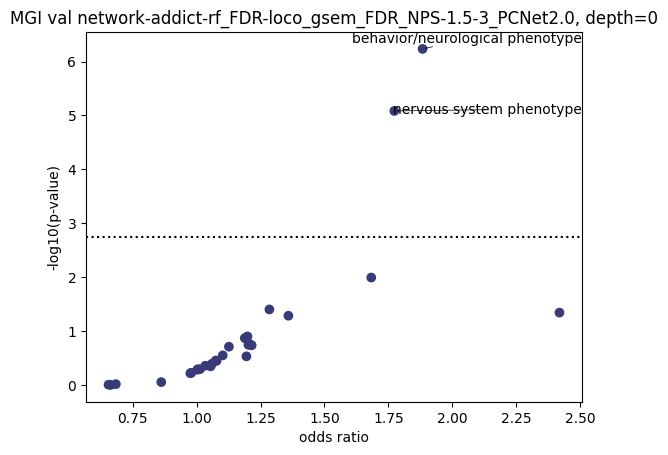

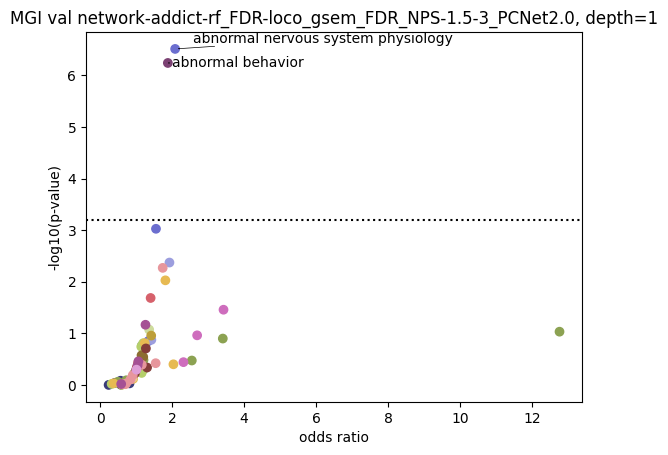

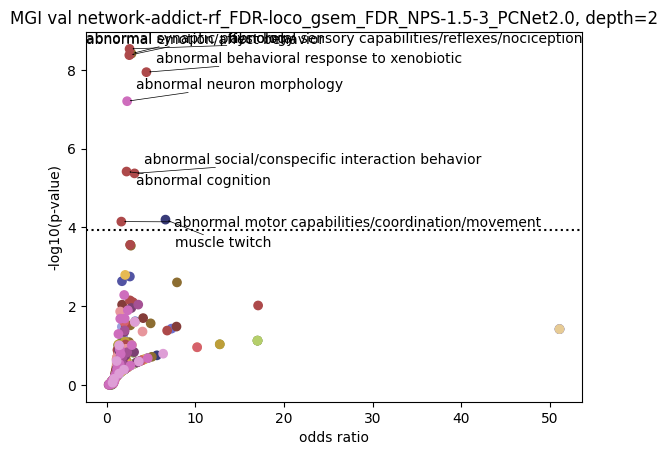

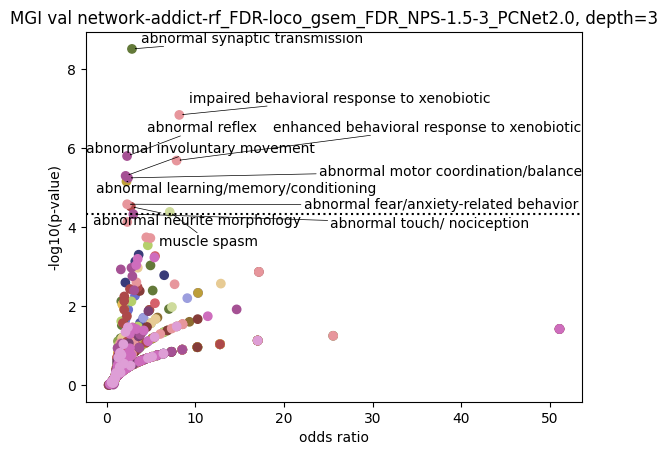

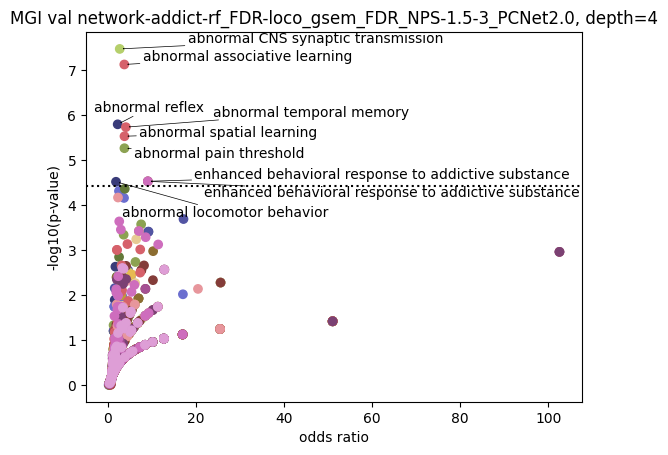

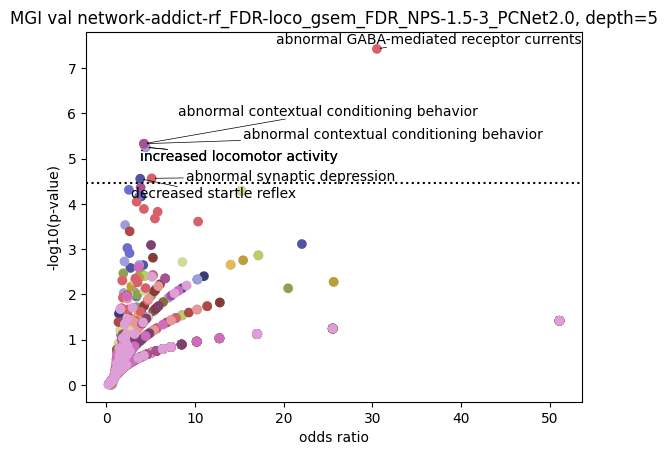

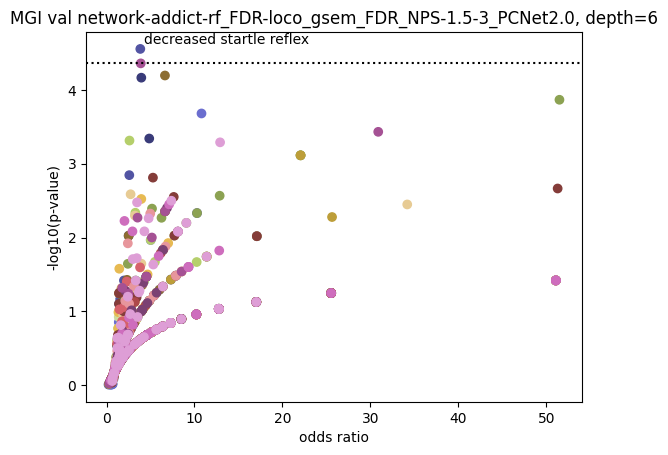

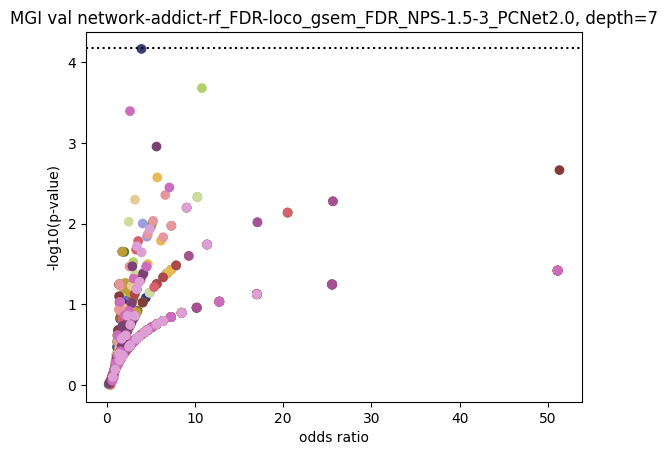

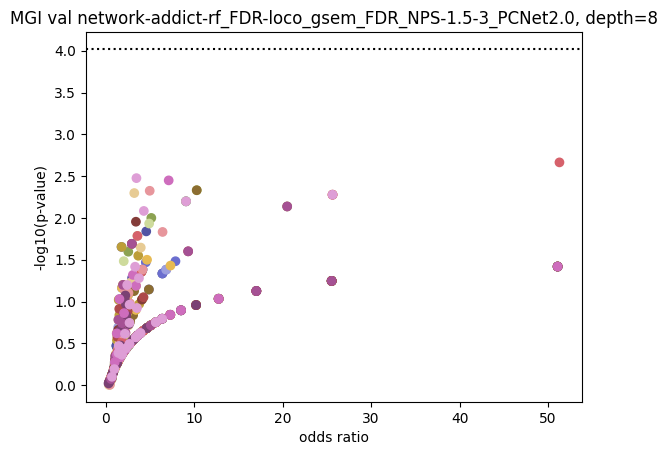

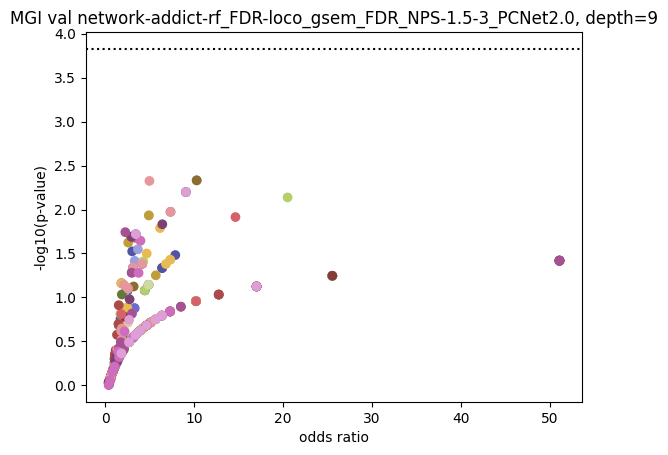

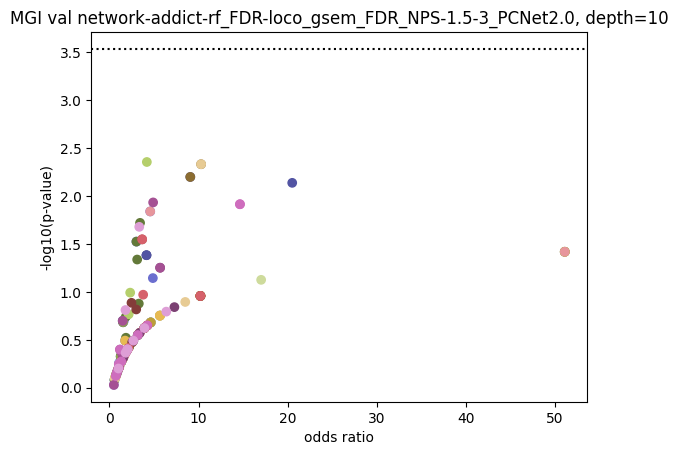

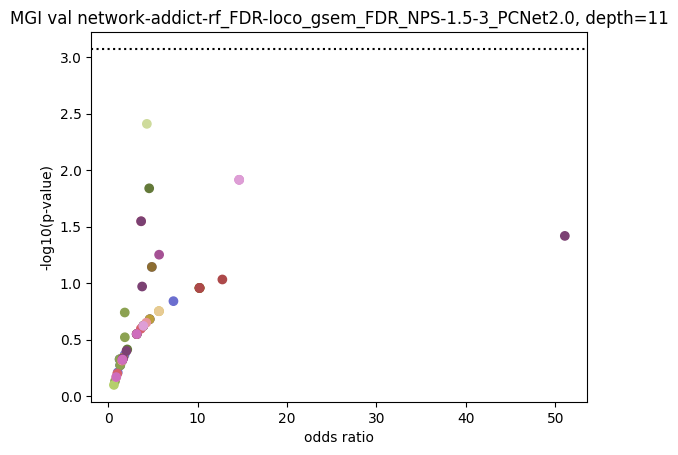

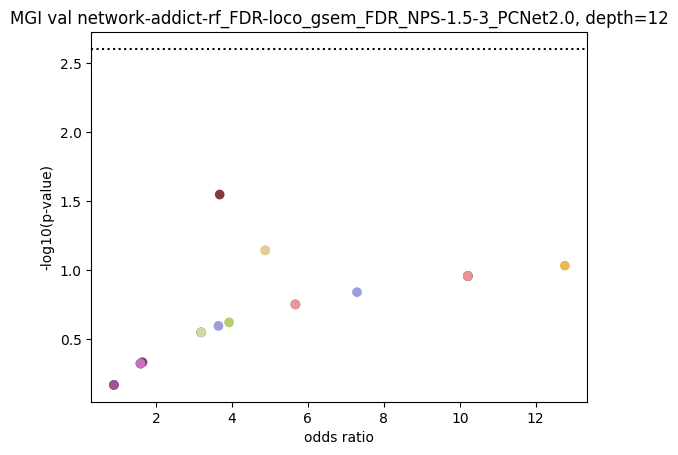

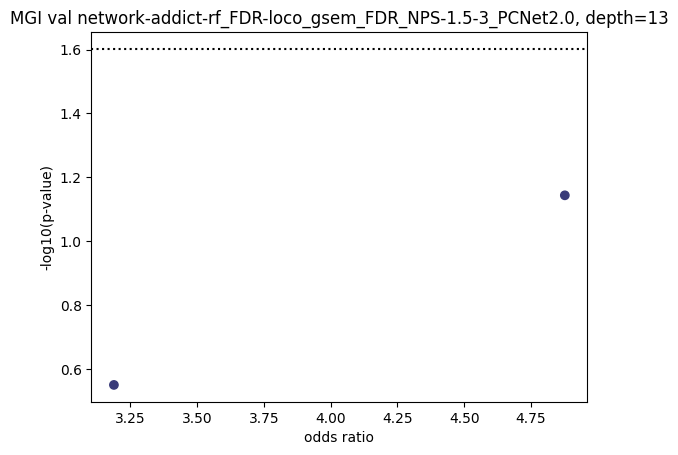

In [44]:
for d in set(tbl.depth):
    t=tbl[tbl.depth==d]
    unique_traits = t.parent_trait.unique()
    color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}
    colors = [color_mapping[trait] for trait in t.parent_trait]  # Color assignment based on parent_trait

    plt.scatter(x=t.odds_ratio,y=-np.log10(t.p_intersect),color=colors)

    plt.xlabel('odds ratio')
    plt.ylabel('-log10(p-value)')
    plt.axhline(-np.log10(0.05/len(t)),color='black',ls=':',label='bonferroni')
    plt.title(f'MGI val {val_lab_dict[sub_community]}, depth={d}')
    texts = []
    for i in t.index:
        if (t.p_intersect[i]<(0.05/len(t))):
            texts.append(plt.annotate(t.trait[i], (t.odds_ratio[i], -np.log10(t.p_intersect[i]))))
    
    # Adjust text to avoid overlap
    adjust_text(texts, only_move={'points': 'y', 'texts': 'y'}, 
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    
    '''
    legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]
    plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(2, 1))
    '''
    if save_fig:
        if not filter_traits:
            plt.savefig((f'{outpath_dir}/MGI_val_scatter_depth-{d}.svg'), bbox_inches = "tight")
        else:
            plt.savefig((f'{outpath_dir}/MGI_val_filtered_scatter_depth-{d}.svg'), bbox_inches = "tight")

    plt.show()

## barplot

/tmp/ipykernel_629305/121538871.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


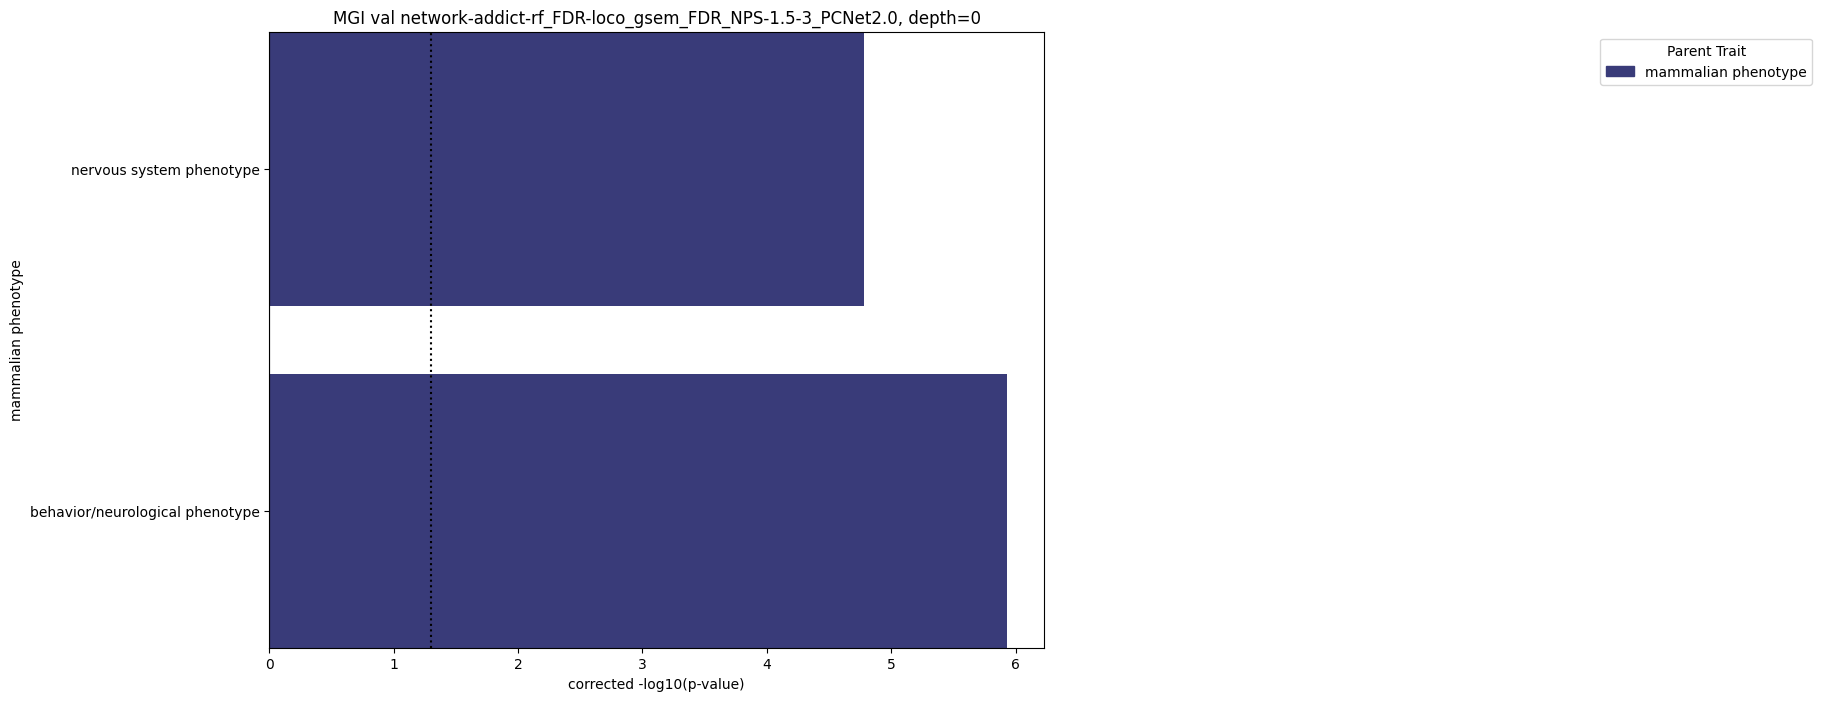

<Figure size 640x480 with 0 Axes>

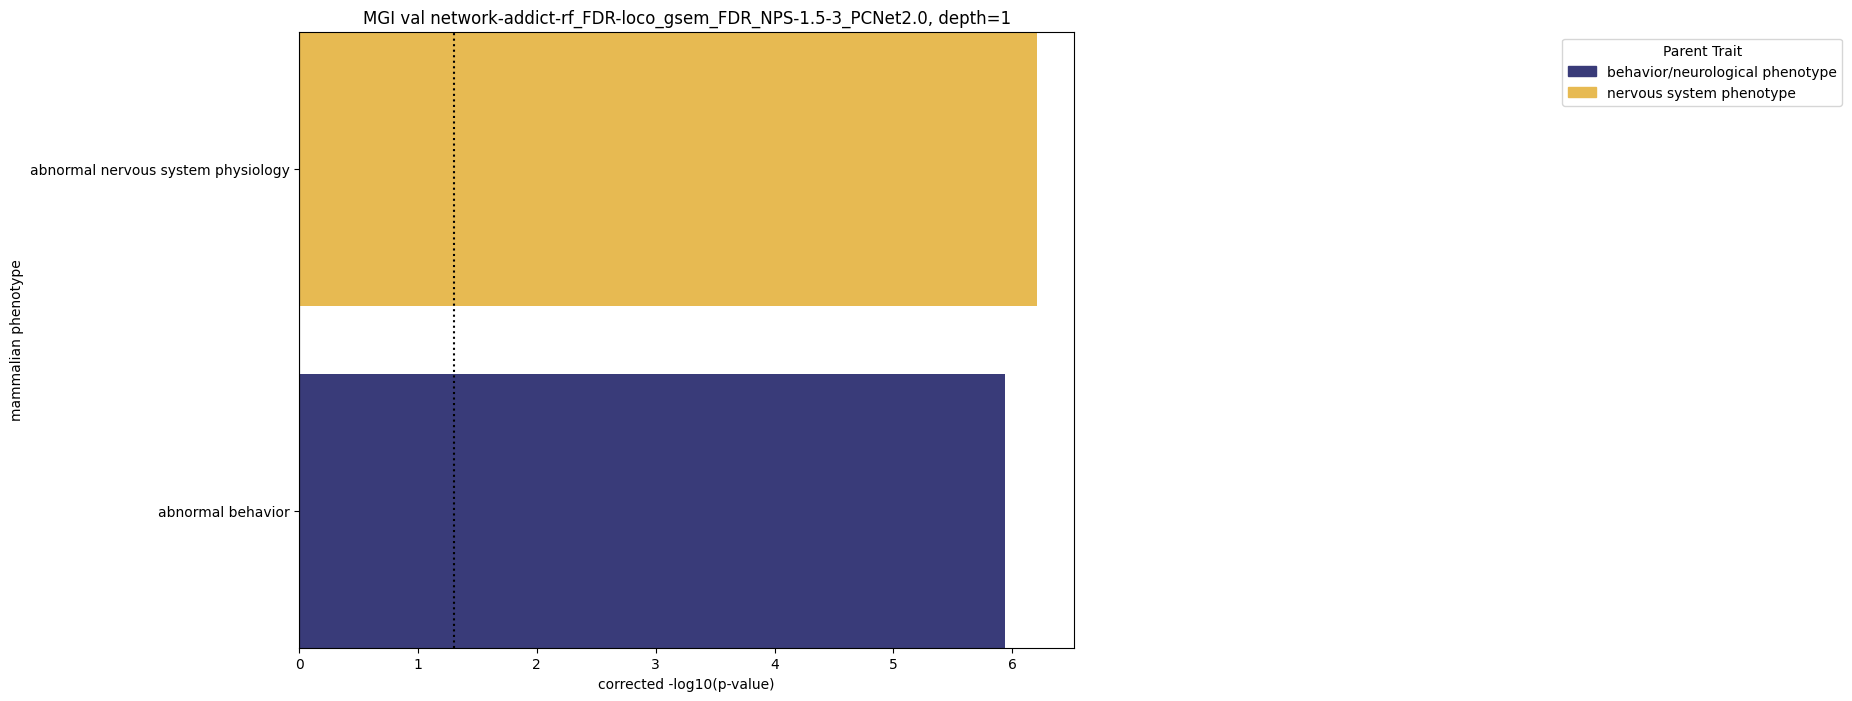

<Figure size 640x480 with 0 Axes>

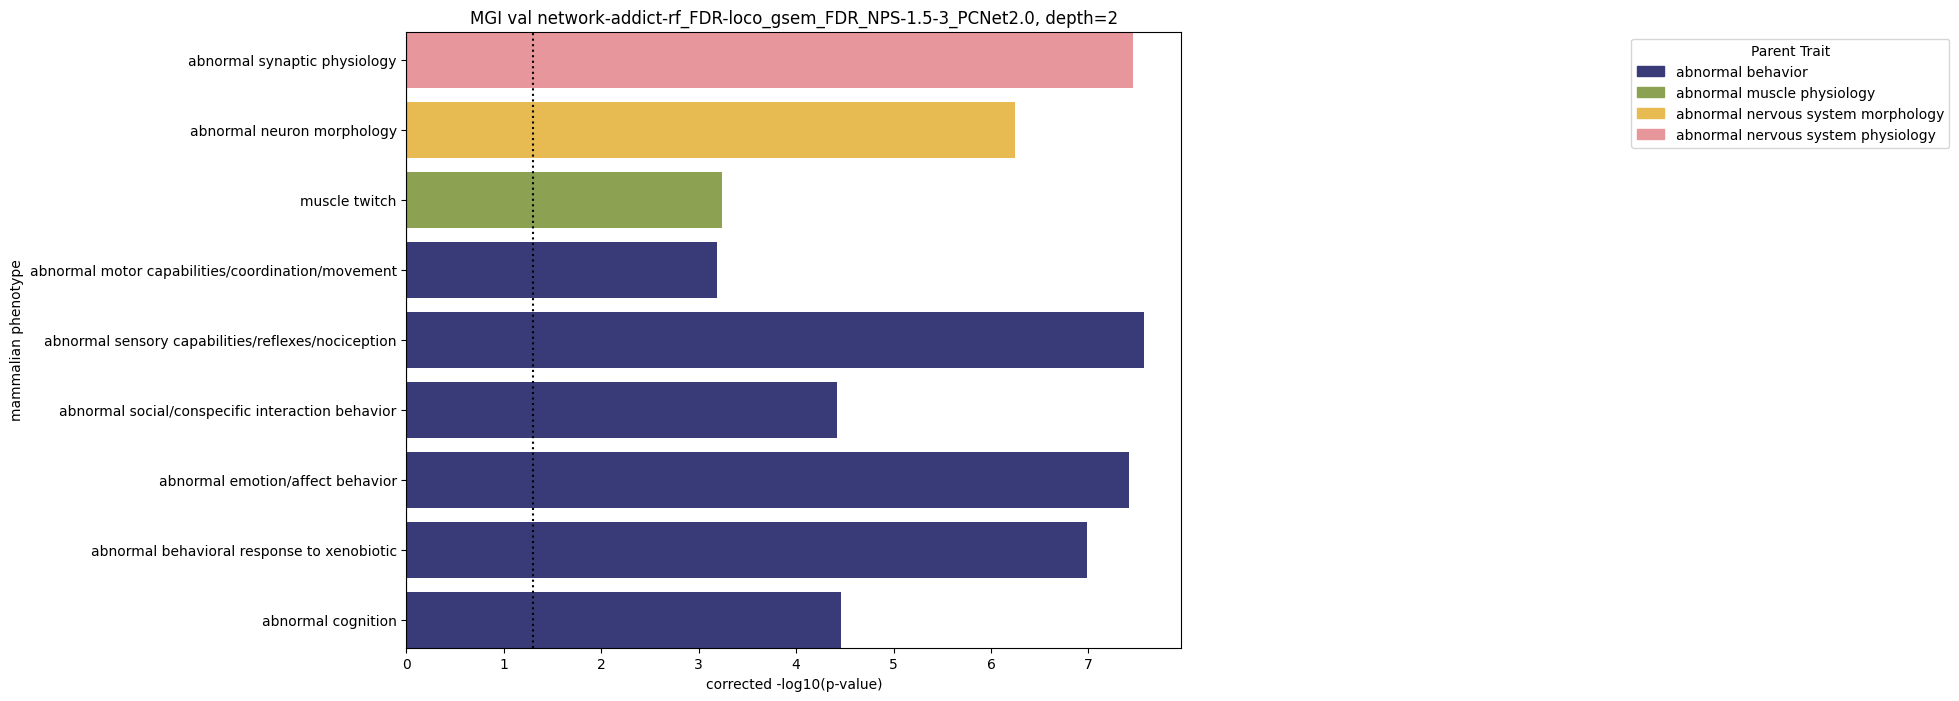

<Figure size 640x480 with 0 Axes>

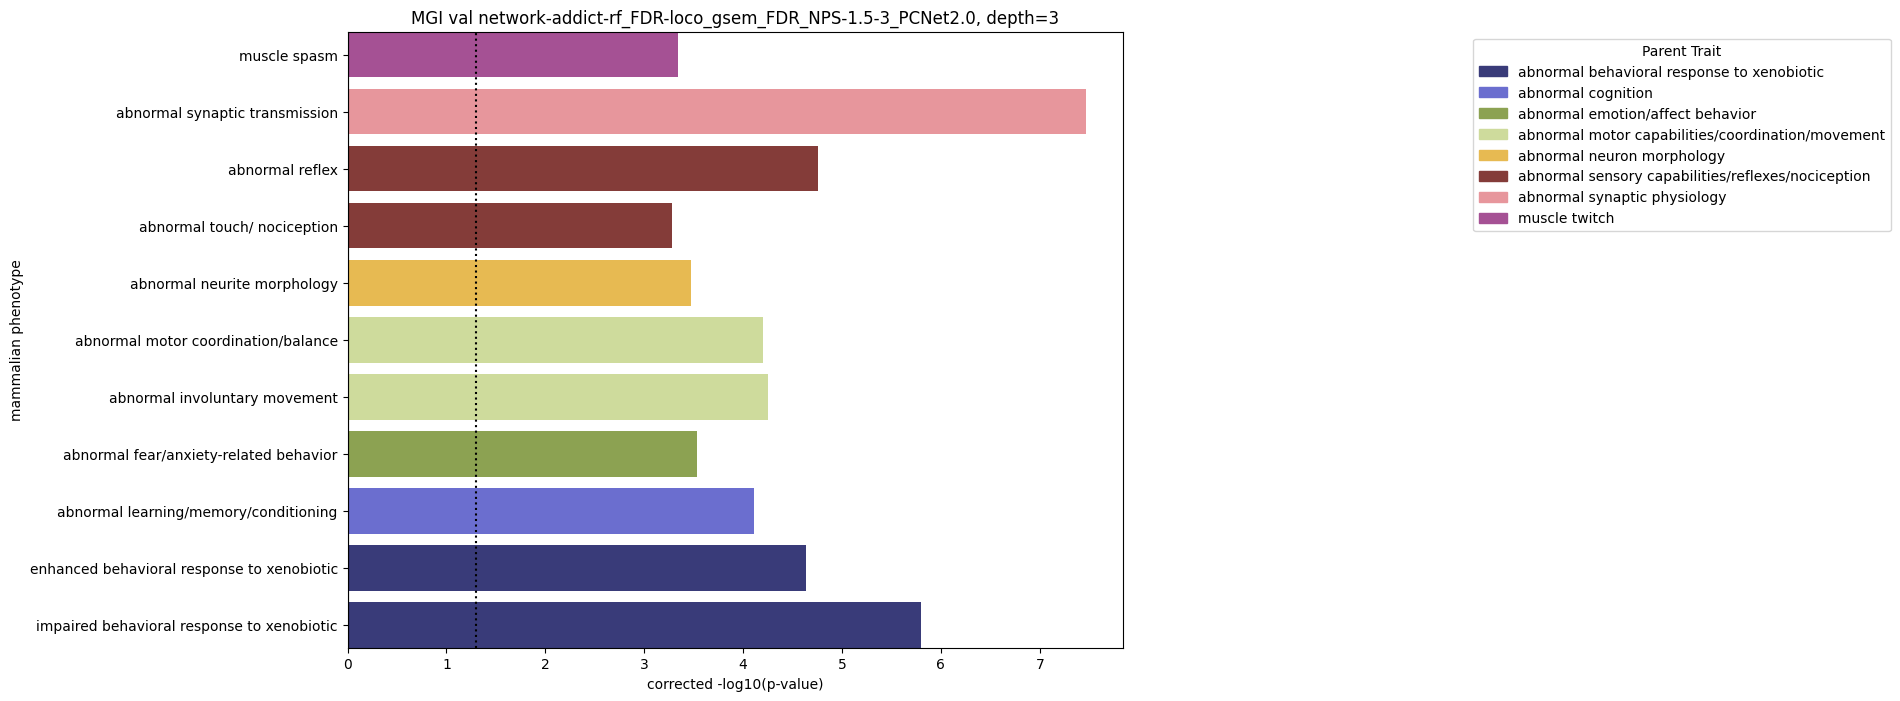

<Figure size 640x480 with 0 Axes>

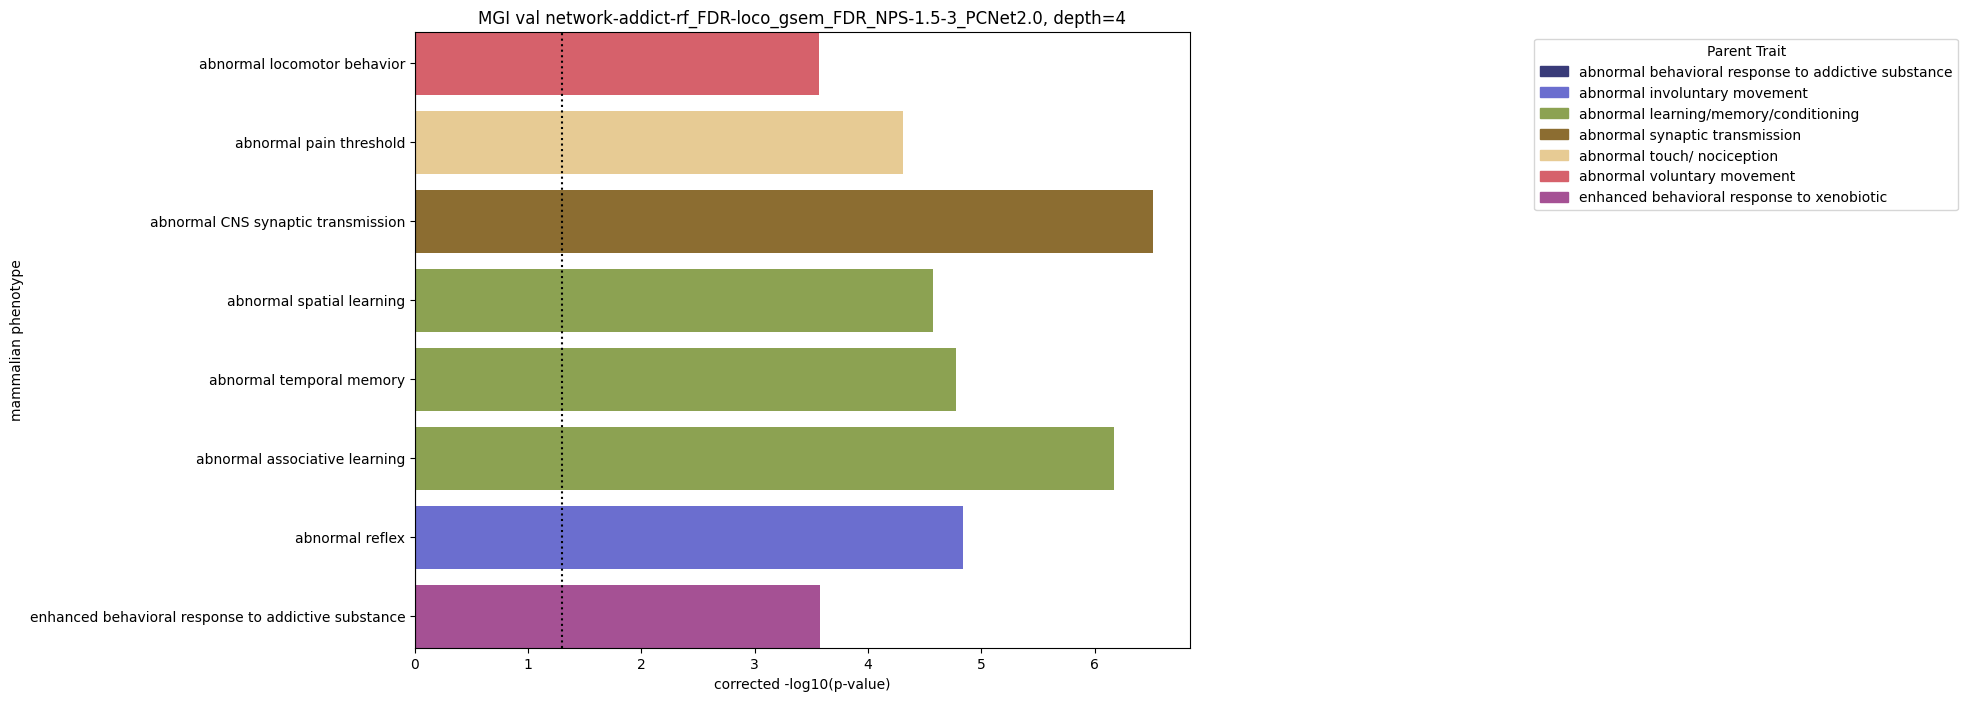

<Figure size 640x480 with 0 Axes>

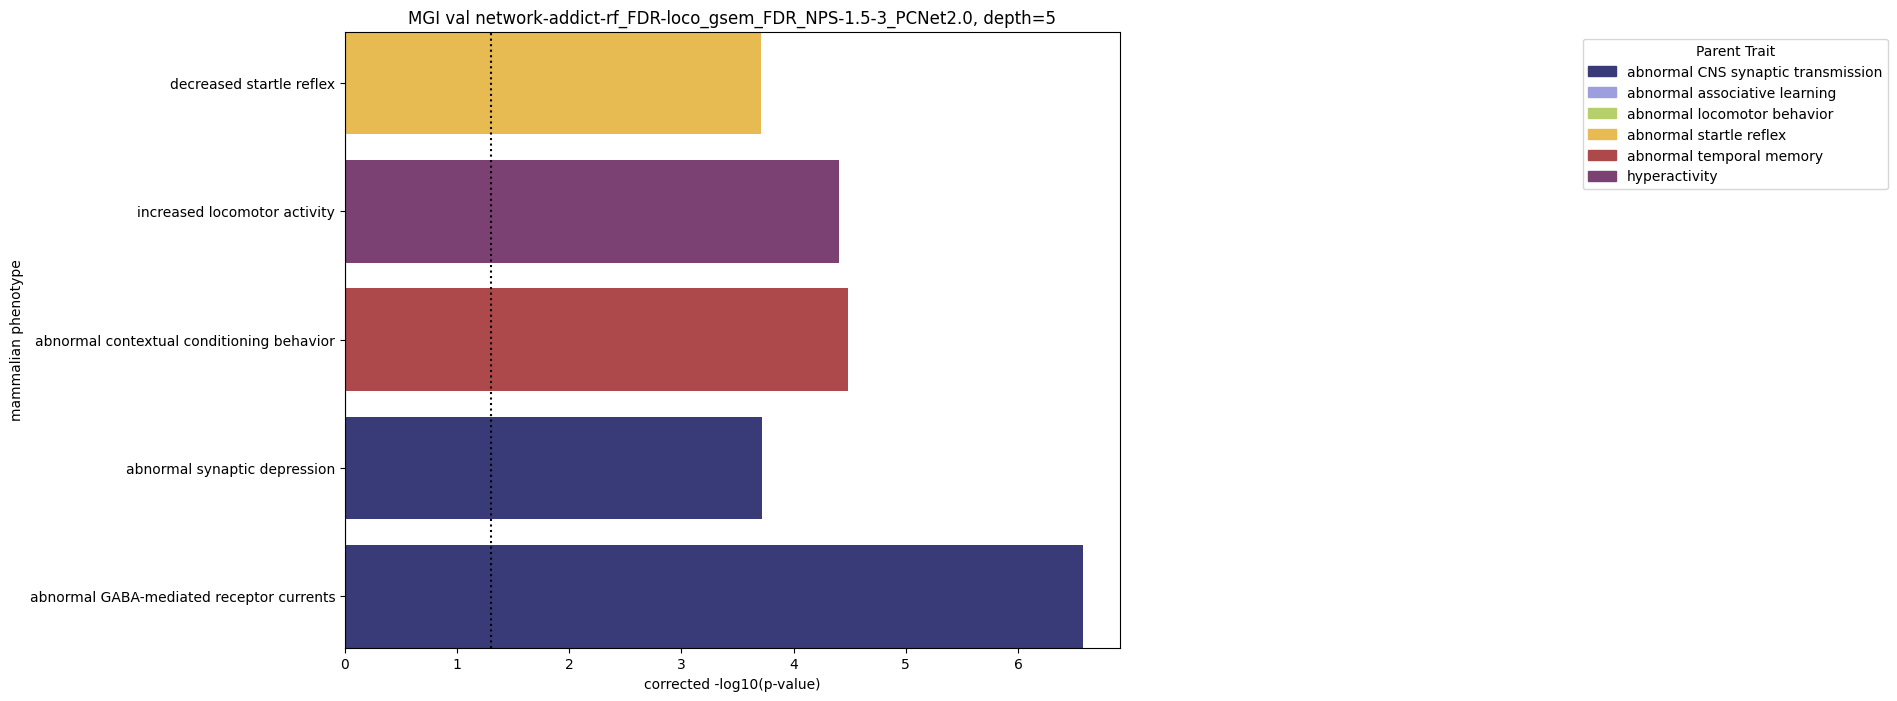

<Figure size 640x480 with 0 Axes>

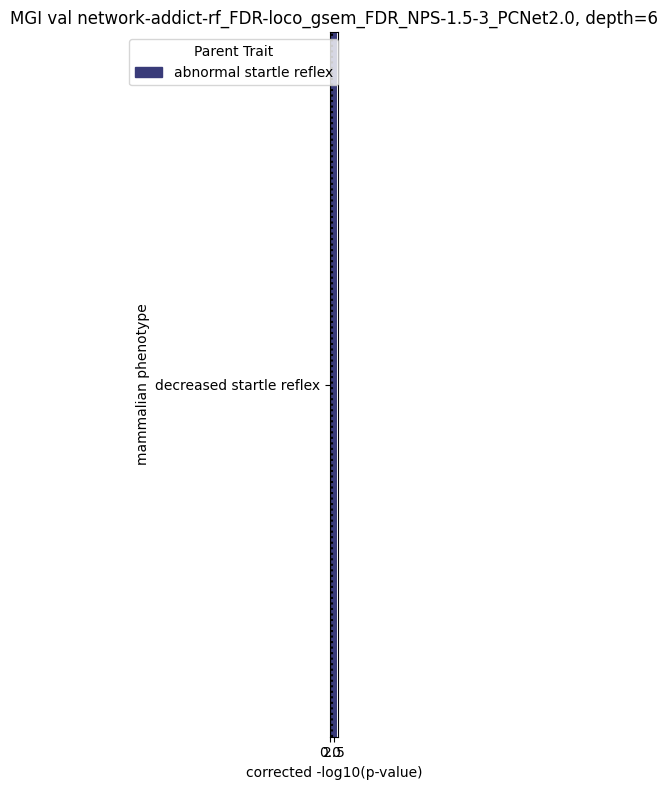

<Figure size 640x480 with 0 Axes>

In [45]:
for d in range(0, max(tbl.depth)+1):
    t = tbl[tbl['depth'] == d]
    t=t[t['p_intersect']<0.05/len(t)]
    if (len(t)>0):
        t=t.sort_values('parent_trait',ascending=True)
        # Assign a unique color for each parent_trait based on its index
        unique_traits = t.parent_trait.unique()
        color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}
        
        # Plotting
        fig = plt.figure(figsize=(10, 8))
        colors = [color_mapping[trait] for trait in t.parent_trait]  # Color assignment based on parent_trait
        
        plt.barh(y=t.trait, width=-np.log10(t.p_intersect*len(t)),label=t.parent_trait, color=colors)
        
        plt.ylabel('mammalian phenotype')
        plt.xlabel('corrected -log10(p-value)')
        plt.axvline(-np.log10(0.05), color='black', ls=':')
        plt.axvline(0, color='black', ls='-')
    
        #plt.xticks(rotation=90)
        #plt.title(d)
        plt.title(f'MGI val {val_lab_dict[sub_community]}, depth={d}')
        # Create legend patches (only one for each unique parent_trait)
        legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]
        
        # Add legend to the plot
        plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(2, 1))
        plt.tight_layout()
        plt.margins(y=0)
        # Show the plot
        if save_fig:
            if not filter_traits:
                plt.savefig((f'{outpath_dir}/MGI_val_bar_depth-{d}.svg'), bbox_inches = "tight")
            else:
                plt.savefig((f'{outpath_dir}/MGI_val_filtered_bar_depth-{d}.svg'), bbox_inches = "tight")

        plt.show()

        # Clear the figure after showing
        plt.clf()

# barplot for figures

In [28]:
save_fig=True

In [23]:
outpath_dir

'validation_output/MGI_enr_network-ext_top500-loco_gsem_FDR_NPS-1.5-3_PCNet2.0_enr'

In [37]:
plt.rcParams.update({'font.size': 16})

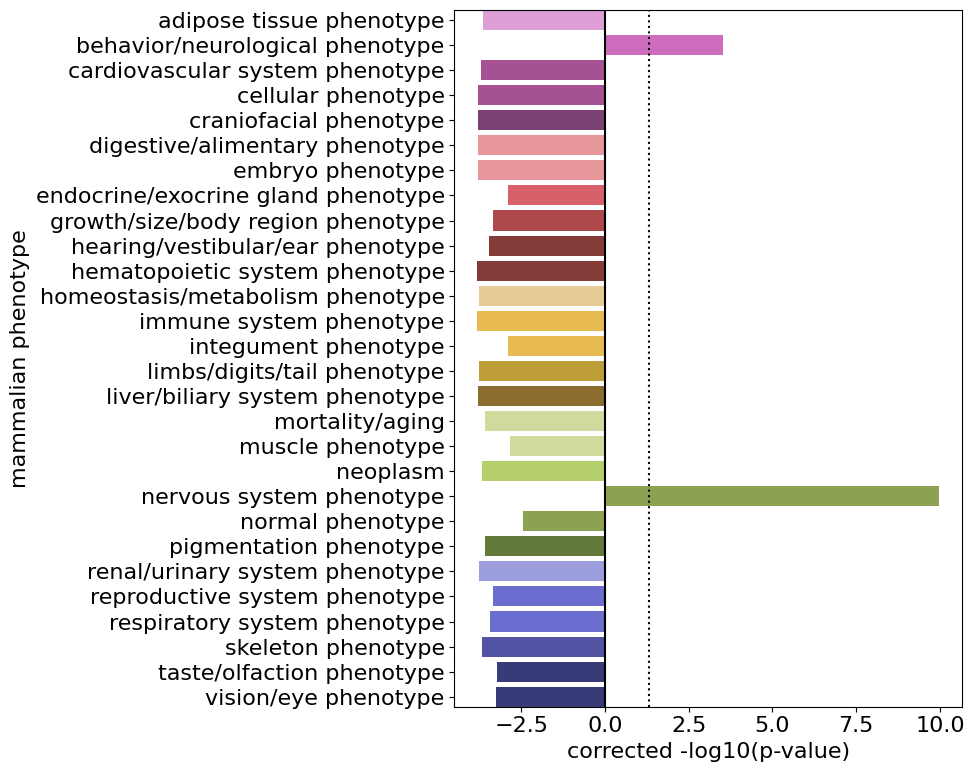

<Figure size 640x480 with 0 Axes>

In [39]:
d=0

t = tbl[tbl['depth'] == d]
t=t.sort_values('trait',ascending=False)
#t=t[t['p_intersect']<0.05/len(t)]
# Assign a unique color for each parent_trait based on its index
unique_traits = t.trait.unique()
color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}

# Plotting
fig = plt.figure(figsize=(10, 8))
colors = [color_mapping[trait] for trait in t.trait]  # Color assignment based on parent_trait

plt.barh(y=t.trait, width=-np.log10(t.p_intersect*len(tbl)),label=t.parent_trait, color=colors)

plt.ylabel('mammalian phenotype')
plt.xlabel('corrected -log10(p-value)')
plt.axvline(-np.log10(0.05), color='black', ls=':')
plt.axvline(0, color='black', ls='-')

#plt.xticks(rotation=90)
#plt.title(d)
# Create legend patches (only one for each unique parent_trait)
legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]

# Add legend to the plot
#plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(2, 1))
plt.tight_layout()
plt.margins(y=0)
# Show the plot
if save_fig:
    plt.savefig((f'{outpath_dir}/MGI_val_depth-{str(d)}_for_publication.svg'), bbox_inches = "tight")
#plt.savefig(('MGI_val_depth-'+str(d)+'.svg'), bbox_inches = "tight")
plt.show()

# Clear the figure after showing
plt.clf()

In [25]:
color_mapping={'muscle phenotype':'#E7969C',
'nervous system phenotype':'#B5CF6B',
'behavior/neurological phenotype':'#A55194'}

In [26]:
with open('GWAS_catalog_parent_terms.txt') as json_file:
    par_dict = json.load(json_file)

In [29]:
par_dict=tbl[tbl['depth']==1][['trait','parent_trait']]
par_dict.index=par_dict.trait
par_dict=par_dict['parent_trait'].to_dict()

/tmp/ipykernel_1777297/3073754772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['grand_parent_trait']=[par_dict[k] for k in t.parent_trait]
/tmp/ipykernel_1777297/3073754772.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


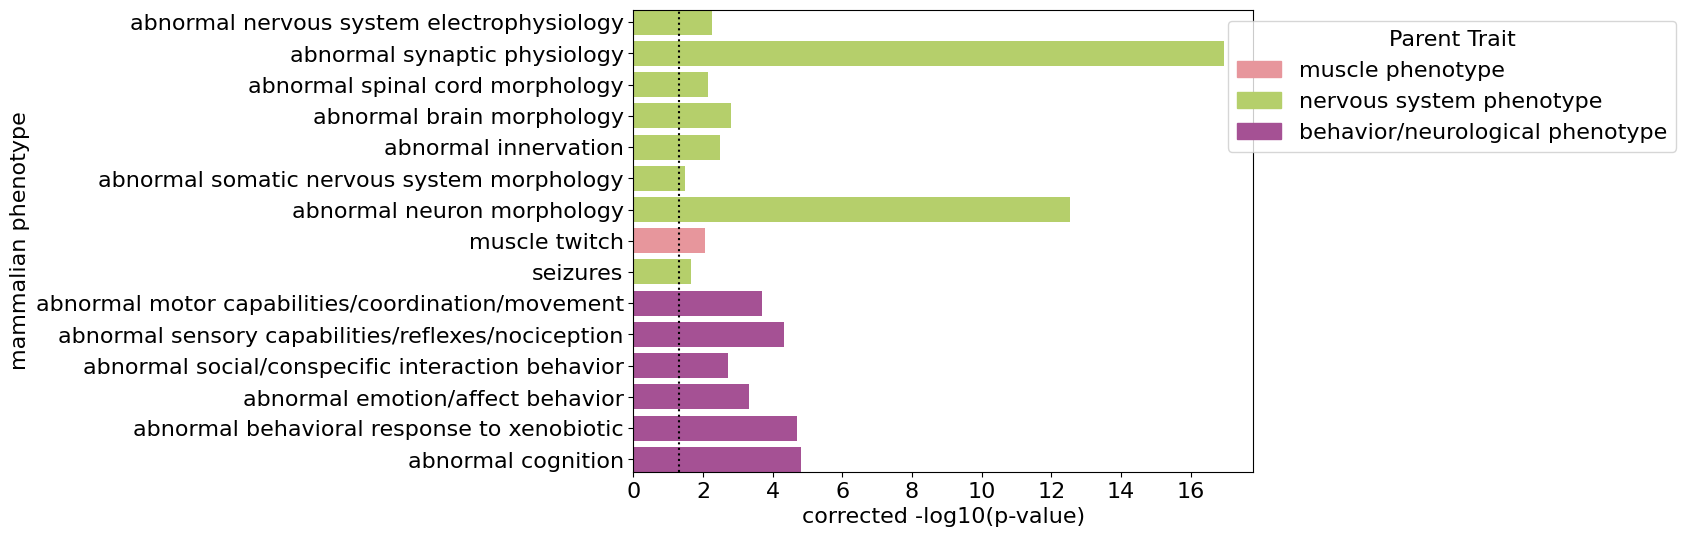

<Figure size 640x480 with 0 Axes>

In [41]:
d=2
t = tbl[tbl['depth'] == d]
t['grand_parent_trait']=[par_dict[k] for k in t.parent_trait]
t=t[t['p_intersect']<0.05/len(tbl)]
#t=t.sort_values('grand_parent_trait',ascending=True).reset_index()
t=t.sort_values('parent_trait')

# Assign a unique color for each parent_trait based on its index
unique_traits = set(t.grand_parent_trait)
#color_mapping = {trait: colormap(i / len(unique_traits)) for i, trait in enumerate(unique_traits)}
color_mapping={'muscle phenotype':'#E7969C',
'nervous system phenotype':'#B5CF6B',
'behavior/neurological phenotype':'#A55194'}
# Plotting
fig = plt.figure(figsize=(8, 6))
colors = [color_mapping[trait] for trait in t.grand_parent_trait]  # Color assignment based on parent_trait

#colors=(['#A55194']*6)+['#E7969C']+(['#B5CF6B']*8)
plt.barh(y=t.trait, width=-np.log10(t.p_intersect*len(tbl)),label=t.grand_parent_trait, color=colors)

plt.ylabel('mammalian phenotype')
plt.xlabel('corrected -log10(p-value)')
plt.axvline(-np.log10(0.05), color='black', ls=':')
#plt.xticks(rotation=90)
#plt.title(d)
# Create legend patches (only one for each unique parent_trait)
legend_patches = [mpatches.Patch(color=color_mapping[trait], label=trait) for trait in unique_traits]

# Add legend to the plot
plt.legend(handles=legend_patches, title='Parent Trait', loc='upper right',bbox_to_anchor=(1.7, 1))
plt.tight_layout()
plt.margins(y=0)
# Show the plot
if save_fig:
    plt.savefig((f'{outpath_dir}/MGI_val_depth-{str(d)}_for_publication.svg'), bbox_inches = "tight")

plt.show()

# Clear the figure after showing
plt.clf()

In [43]:
24/26.791*100

89.58232242170878